<a href="https://colab.research.google.com/github/Isi2000/PATTERN/blob/main/PATTERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data an and plotting 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random

#torch 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as Ft

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

#working with dirs
import os

In [2]:
#this line of code copies the files in the PATTERN repo
#they are hd image so it may take a while
!git clone https://github.com/Isi2000/PATTERN.git

Cloning into 'PATTERN'...
remote: Enumerating objects: 5872, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 5872 (delta 6), reused 3 (delta 0), pack-reused 5830
Receiving objects: 100% (5872/5872), 1.13 GiB | 18.17 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (5859/5859), done.


# DATASET

First the image paths and labels need to be storged in a pd DataFrame object to later be put in a custom made dataset 

In [16]:
labels_map = {0: 'NORMAL', 1:'BACTERIAL', 2:'VIRAL',}

data_dir_train = '/content/PATTERN/images/t_all'
data_dir_test = '/content/PATTERN/images/test_all'
data_dir_val = '/content/PATTERN/images/val_all'

d_train = {'img_path': os.listdir(data_dir_train)}
d_test = {'img_path': os.listdir(data_dir_test)}
d_val = {'img_path': os.listdir(data_dir_val)}

df_train = pd.DataFrame(d_train)
df_test= pd.DataFrame(d_test)
df_val = pd.DataFrame(d_val)

df_train['label'] = 0
df_test['label'] = 0
df_val['label'] = 0

#these lines work really well, BE CAREFUL BECAUSE IT GIVES A PD WARNING 

#DIOCANE
df_train.loc[df_train['img_path'].str.contains('virus'), 'label'] = 2
df_train.loc[df_train['img_path'].str.contains('bacte'), 'label'] = 1
df_test.loc[df_test['img_path'].str.contains('virus'), 'label'] = 2
df_test.loc[df_test['img_path'].str.contains('bacte'), 'label'] = 1
df_val.loc[df_val['img_path'].str.contains('virus'), 'label'] = 2
df_val.loc[df_val['img_path'].str.contains('bacte'), 'label'] = 1

print(df_train.head())
print(df_test.head())
print(df_val.head())


                       img_path  label
0      person408_virus_815.jpeg      2
1             IM-0191-0001.jpeg      0
2     person721_virus_1340.jpeg      2
3  person783_bacteria_2687.jpeg      1
4  person321_bacteria_1483.jpeg      1
                         img_path  label
0          person21_virus_53.jpeg      2
1       NORMAL2-IM-0376-0001.jpeg      0
2       NORMAL2-IM-0141-0001.jpeg      0
3  NORMAL2-IM-0173-0001-0001.jpeg      0
4       NORMAL2-IM-0315-0001.jpeg      0
                        img_path  label
0  person1951_bacteria_4882.jpeg      1
1  person1949_bacteria_4880.jpeg      1
2      NORMAL2-IM-1442-0001.jpeg      0
3      NORMAL2-IM-1440-0001.jpeg      0
4      NORMAL2-IM-1438-0001.jpeg      0


Transformation and Custome Image Dataset. The class is written following to pytorch standards 
(for more info see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [17]:
#stands for pixels, it's for resizing

pix = 224

transform_1 = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Grayscale(),    
     #the resizing must be fixed according to training perf
     #224 is the standard size for resnets
     transforms.Resize(size = (pix, pix), antialias = False),
     transforms.Normalize(mean=[0.0], std=[1.0]),
     #this one is for resnet
     transforms.Lambda(lambda x: x.repeat(3,1,1)),
     ])

class CustomImageDataset(Dataset):
    def __init__(self, pd_df, img_dir, transform=None, target_transform=None):
        self.img_labels = pd_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_ = CustomImageDataset(df_train, data_dir_train, transform = transform_1)
test_ = CustomImageDataset(df_test, data_dir_test, transform = transform_1)
val_ = CustomImageDataset(df_val, data_dir_val, transform = transform_1)

Data visualization of the dataset

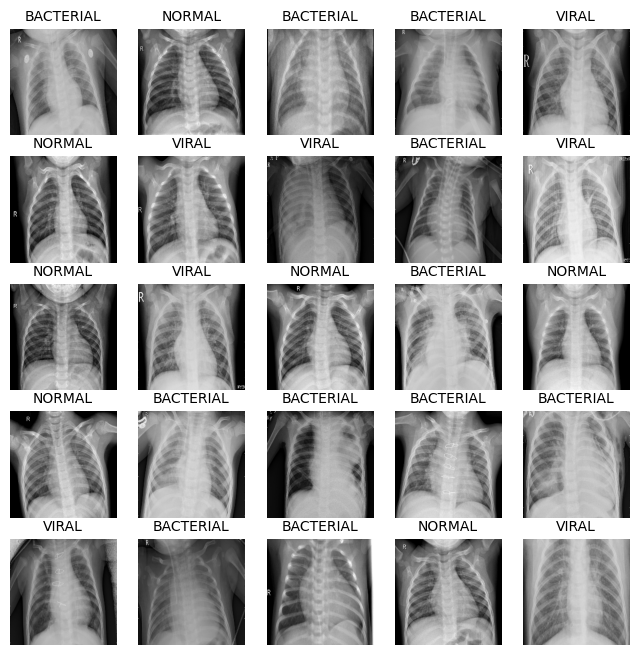

In [18]:
def plotter(data):      
    """this plots 9 images from a dataset"""
    figure = plt.figure(figsize = (8,8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = Ft.to_pil_image(data[sample_idx][0]) , data[sample_idx][1]
        #print(img.size)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.title(labels_map[label], fontsize = 10)
        plt.imshow(img)        
    plt.show()

plotter(train_)

# Neural Network and GPU

The code below tells the program to use gpu if available. All the code written is designed to work even if the machine doesn't have a gpu

In [19]:
if torch.cuda.is_available():
    print("Congratulations, you have a GPU!")
else:
    print("PyTorch cannot see your GPU :(")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Congratulations, you have a GPU!


# Resnet
The Neural Network chosen is resnet50. It is a pretrained NN that performs really well on computer vision problem. It takes as input 3 channels 224x224 images and it classifies them into 1000 classes

In [51]:
from torchvision.models import googlenet

net = googlenet(num_classes = 3,pretrained=False, aux_logits=False ).to(torch.device('cuda'))

The input channels can be fixed with a simple transformation. For what concerns the output, the output of the net can be connected to a fully connected layer with label 3 outputs

In [52]:
summary(net, (3, pix, pix), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# Training and Testing

In [53]:

loss_fn = torch.nn.CrossEntropyLoss()
m = nn.LogSoftmax(dim=1)

#Adam may be too strong
optimizer = optim.AdamW(net.parameters(), lr=1e-6, weight_decay=1e-5)

train_loader = DataLoader(train_, batch_size=50, shuffle=True, num_workers = 2)
test_loader = DataLoader(test_, batch_size=50, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_, batch_size=10, shuffle=True)



def train(model, device, train_loader, optimizer, epoch, freq=20):
    model.train()
    epoch_loss = 0    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(m(output), target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % freq == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        
        epoch_loss += loss.item()
            
    return epoch_loss / len(train_loader)


def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(m(output), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

# ATTENTO ISACCO

NOTE: as suggested by kharphaty it is always usefull to check inital loss.
With softmax and 3 classes we expect initial loss to be around -ln(0.33) = 1.1, this is fully compatible with what we observe with a pretrained net

ATTENTO, QUALCOSA NON VA!!!!!!!!!!!!!


In [54]:
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 15
best_params = net.state_dict()
best_accuracy = 0

test_accuracy = 0
epoch = 0
while test_accuracy < 85:
    print('Train Epoch: {}'.format(epoch))
    train_losses.append(train(net, device, train_loader, optimizer, epoch))
    test_loss, test_accuracy = test(net, device, test_loader)
    epoch += epoch
    print(test_accuracy)

    # model selection
    if test_accuracy >= best_accuracy:
        best_accuracy = test_accuracy
        best_params = net.state_dict()

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Train Epoch: 0
Train Epoch: 0 [0/5216 (0%)]	Loss: 1.113530
Train Epoch: 0 [1000/5216 (19%)]	Loss: 1.065086
Train Epoch: 0 [2000/5216 (38%)]	Loss: 1.048227
Train Epoch: 0 [3000/5216 (57%)]	Loss: 0.993037
Train Epoch: 0 [4000/5216 (76%)]	Loss: 0.975018
Train Epoch: 0 [5000/5216 (95%)]	Loss: 0.989414

Test set: Average loss: 0.9731, Accuracy: 372/624 (60%)

59.61538461538461
Train Epoch: 0
Train Epoch: 0 [0/5216 (0%)]	Loss: 0.930007
Train Epoch: 0 [1000/5216 (19%)]	Loss: 0.957508
Train Epoch: 0 [2000/5216 (38%)]	Loss: 0.910969
Train Epoch: 0 [3000/5216 (57%)]	Loss: 0.842135
Train Epoch: 0 [4000/5216 (76%)]	Loss: 0.831287
Train Epoch: 0 [5000/5216 (95%)]	Loss: 0.893151

Test set: Average loss: 0.8777, Accuracy: 397/624 (64%)

63.62179487179487
Train Epoch: 0
Train Epoch: 0 [0/5216 (0%)]	Loss: 0.854980
Train Epoch: 0 [1000/5216 (19%)]	Loss: 0.768899
Train Epoch: 0 [2000/5216 (38%)]	Loss: 0.802457
Train Epoch: 0 [3000/5216 (57%)]	Loss: 0.734946
Train Epoch: 0 [4000/5216 (76%)]	Loss: 0.859647

KeyboardInterrupt: ignored

# RESULTS

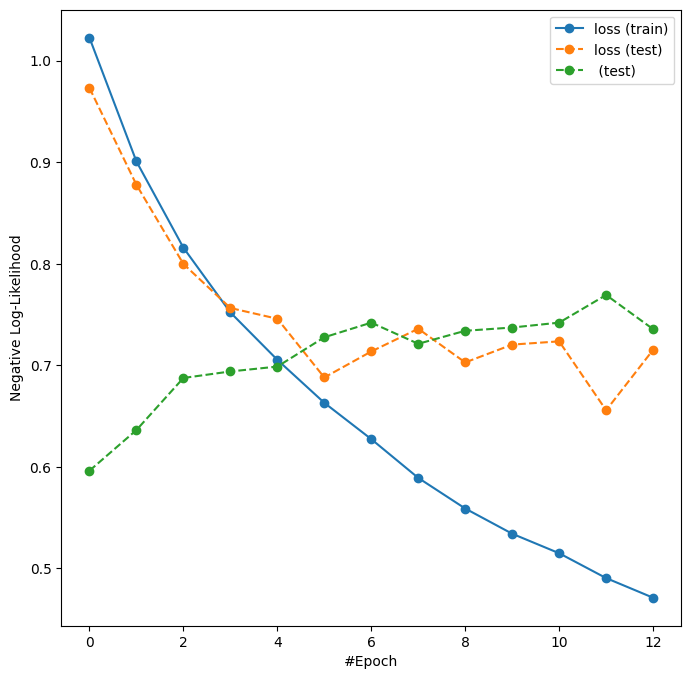

In [55]:

plt.figure(figsize=(8, 8))
a = []
for i in test_accuracies:
  a.append(i / 100)

plt.plot(train_losses, marker='o', label='loss (train)')
plt.plot(test_losses, marker='o', linestyle='dashed', label='loss (test)')
plt.plot(a, marker='o', linestyle='dashed', label=' (test)')



plt.xlabel('#Epoch')
plt.ylabel('Negative Log-Likelihood')

plt.legend()
plt.show()


In [ ]:
# resume best model
net.load_state_dict(best_params)
best_accuracy

In [ ]:
#since this validaion is basically additional testing I think I can keep the same function
test(net, device , val_loader )
#this tells me its not working at all